In [3]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")

using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [4]:
function get_vf_for_parameters(params)
    a1, b1, a2, b2, c1, c2 = params
    f(u1, u2) =    [-a1 * u1 + b1*(c1-u1)*u2
                    -a2 * u2 + b2*(c2-u2)*u1]
    return f
end

get_vf_for_parameters (generic function with 1 method)

Solving ODE from x0=[0.4, 0.1]
size(sol) = (2, 11)
length = 10


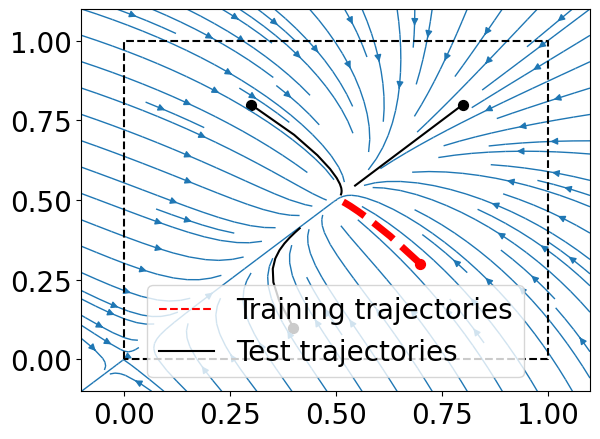

Solving ODE from x0=[0.8, 0.8]
size(sol) = (2, 8)
length = 10
Solving ODE from x0=[0.3, 0.8]
size(sol) = (2, 11)
length = 10
Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 10)
length = 10


PyObject <matplotlib.legend.Legend object at 0x7f8f772780d0>

In [5]:
gr(size=(600,400))


ode_p = [.05 .1 .05 .1 1. 1.]
ff = get_vf_for_parameters(ode_p)

plot_vectorfield(ff, (-0.1, 1.1, 50), (-0.1, 1.1, 50))

initial_conditions = [ [.7, .3], [.4, .1], [.8, .8], [.3, .8]]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in initial_conditions[2:end]
    sol = solve_ode(ff, x0, tspan = (0., 30.0))
    PyPlot.plot(sol..., color=:black)
    PyPlot.scatter(x0[1], x0[2], color=:black, s=50)
end

x0 = initial_conditions[1]
sol = solve_ode(ff, x0)
PyPlot.plot(sol..., color=:red, ls="--", lw=5)
PyPlot.scatter(x0[1], x0[2], color=:red, s=50)
PyPlot.plot([], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot([], [], color=:black, label="Test trajectories")
plot_box()
PyPlot.legend()


In [6]:
function get_training_data(x0; noise_level=1e-6, verbose=true, length=10)
    Random.seed!(0)
    training_x = hcat(solve_ode(ff, x0; verbose=verbose, length=length)...)'
    training_xdot = ff.(training_x[1, :], training_x[2, :])
    training_xdot = hcat(training_xdot...)
    training_xdot = training_xdot + noise_level * randn(size(training_xdot))
    return training_x, training_xdot
end


∞ = 1e9
function test_error(vf, initial_conditions; verbose=false)
    penalty = u -> sum(u.^2)
    error = 0
    for x0 in initial_conditions
        sol = []
        try
            sol = solve_ode(vf, x0, verbose=verbose)
        catch y
            return ∞
        end
        true_sol =  solve_ode(ff, x0, verbose=verbose)
        for  i=1:size(sol, 1)
            error += penalty(sol[i] .- true_sol[i])
        end
        if verbose
            println("at $x0, error = $error")
        end
    end
    return error / size(initial_conditions, 1)
end

# should ne 0
test_error(ff, initial_conditions[2:end])


0.0

In [7]:
box_invariance(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p

   
    int_y = @set x2 >= 0 && 1 - x2 >= 0
    int_x = @set x1 >= 0 && 1 - x1 >= 0

    @constraint(model, subs(p1, x1=>0) >= 0, domain=int_x )
    @constraint(model, -subs(p1, x1=>1) >= 0, domain=int_y )
    @constraint(model, subs(p2, x2=>0) >= 0, domain=int_x )
    @constraint(model, -subs(p2, x2=>1) >= 0, domain=int_y )
end


monotonicity(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p

    Box = @set 1 - x1 >=  0 && x1 >= 0 && 1 - x2 >= 0 && x2 >= 0
    @constraint(model, differentiate(p1, x2) >= 0, domain=Box)
    @constraint(model, differentiate(p2, x1) >= 0, domain=Box)
end

equilibrium_points(model, p, x) = begin
    @constraint model p[1](0, 0) == 0
    @constraint model p[2](0, 0) == 0
end

equilibrium_points (generic function with 1 method)

Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 10)
length = 1000
n = 2
size(training_xdot) = (2, 1000)
size(training_x) = (2, 1000)
deg = 2
solver = MathOptInterface.OptimizerWithAttributes(Mosek.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawParameter("QUIET") => true])
Define polynomial variable
Define p(training)
side_info = Dict{String, Function}("equilibrium_points" => equilibrium_points, "box_invariance" => box_invariance, "monotonicity" => monotonicity)
Imposing equilibrium_points
Imposing box_invariance
Imposing monotonicity
Define objective
Solving
value(objective) = 0.00966813545548482
round.(p_opt, digits = 2) = 

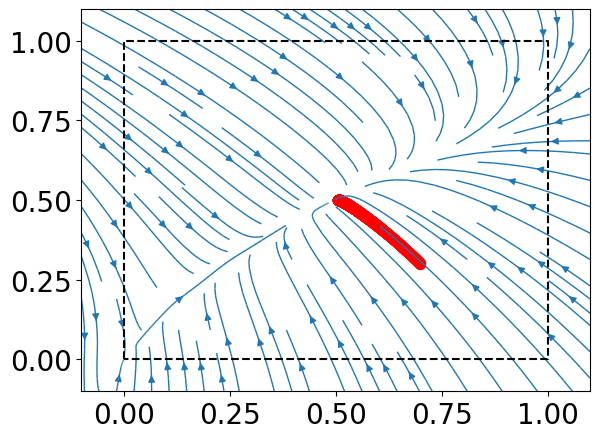

Polynomial{true, Float64}[-0.06x₁² + 0.07x₂², -0.1x₁x₂ + 0.1x₁ - 0.05x₂]
round.(opt_value, digits = 6) = 0.009668


In [8]:
verbose = true
deg = 2
noise_level=0*1e-4
training_x, training_xdot = get_training_data(initial_conditions[1],
                                        noise_level=noise_level, 
                                         verbose=verbose, length=1000)
# data_x = [0.7 0.6743 0.651733 0.631992 0.614775 0.599795 0.586786 0.575503 0.565731 0.557274 0.549955 0.543627 0.538154 0.533421 0.529324 0.525778 0.522708 0.520048 0.517738 0.515732; 0.3 0.332724 0.360048 0.382911 0.402075 0.418161 0.431681 0.443055 0.452628 0.460689 0.46748 0.473199 0.478011 0.482062 0.485469 0.488331 0.490729 0.492736 0.494415 0.495815]
# data_y = [-0.0259321 -0.0229135 -0.0199887 -0.0175017 -0.0153012 -0.0133236 -0.0114618 -0.0100023 -0.00879107 -0.00724013 -0.00647079 -0.00547157 -0.00480303 -0.00421488 -0.00358632 -0.00298889 -0.00265446 -0.00228428 -0.00204884 -0.00161675; 0.0340828 0.0283447 0.0237351 0.0198431 0.0168126 0.013914 0.0118452 0.00988082 0.00808706 0.00704187 0.00585207 0.00496953 0.00420161 0.00357221 0.00288563 0.00252677 0.00205396 0.00179401 0.00127819 0.00135135]
# training_x = data_x
# training_xdot = data_y


side_info = Dict(
    "equilibrium_points" => equilibrium_points,
    "box_invariance" => box_invariance,
     "monotonicity" => monotonicity,
 )

p_opt, opt_value = 
fit_polynomial_to_data_with_side_info(training_x, training_xdot; 
    side_info=side_info, verbose=verbose, deg=deg, regularization=0.)
@show round.(p_opt, digits=2)
@show round.(opt_value, digits=6)

p_opt_as_f = (a, b) ->  map(pi -> pi([a,b]), p_opt)
plot_vectorfield(p_opt_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
PyPlot.scatter(training_x[1,:], training_x[2, :], color=:red, s=50)
plot_box();


In [9]:
l2_error = sum( (hcat(p_opt_as_f.(training_x[1, :], training_x[2, :],)...) .- training_xdot).^2)
diff_f = p_opt - ff(variables(p_opt)...) 
coeff_error = norm(hcat(coefficients.(diff_f)...))
println("p - f = ", round.(diff_f, digits=2))
println("coeff(p - f) = ", coeff_error)
println("l2^2 error: ", l2_error)

p - f = Polynomial{true, Float64}[-0.06x₁² + 0.1x₁x₂ + 0.07x₂² + 0.05x₁ - 0.1x₂, 0.0]
coeff(p - f) = 0.17578189988994564
l2^2 error: 9.347272090080977e-5


# test error on longer horizon

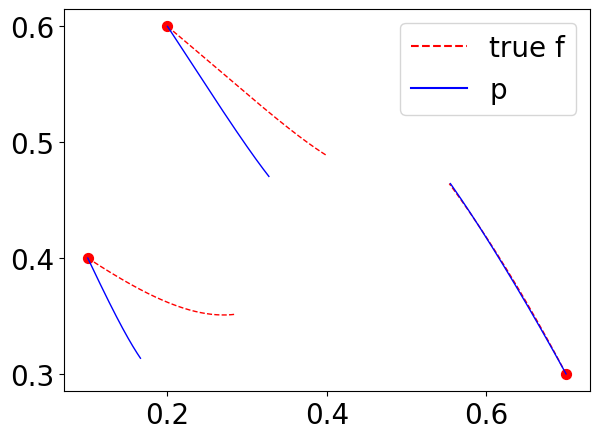

Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 7)
length = 1000
Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 7)
length = 1000
Solving ODE from x0=[0.2, 0.6]
size(sol) = (2, 7)
length = 1000
Solving ODE from x0=[0.2, 0.6]
size(sol) = (2, 6)
length = 1000
Solving ODE from x0=[0.1, 0.4]
size(sol) = (2, 7)
length = 1000
Solving ODE from x0=[0.1, 0.4]
size(sol) = (2, 6)
length = 1000


PyObject <matplotlib.legend.Legend object at 0x7f4fa408b0a0>

In [56]:
T = 10.
N = 1000
test_conditions = [
    x0, [.2, .6], [.1, .4]
]
for x0 in test_conditions
    true_sol = solve_ode(ff, x0, tspan=(0., T), length=N)
    PyPlot.plot(true_sol..., color=:red, ls="--", lw=1)

    approx_sol = solve_ode(p_opt_as_f, x0, tspan=(0., T), length=N)
    PyPlot.plot(approx_sol..., color=:blue, ls="-", lw=1)
    
    PyPlot.scatter(x0[1], x0[2], color=:red, s=50)

end

PyPlot.plot([], [], color=:red, ls="--", label="true f")
PyPlot.plot([],[],  color=:blue, ls="-", label="p")

PyPlot.legend()